# Demo de Deep Autoencoder (DAE) con datos
Basado en:

https://blog.keras.io/building-autoencoders-in-keras.html


https://towardsdatascience.com/deep-autoencoders-using-tensorflow-c68f075fd1a3

In [1]:
#@title Librerías a usar
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.utils import plot_model

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import random
import copy
import math

import os
import csv


import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output

print("\nLibrerías importadas")


Librerías importadas


# Datos:

In [2]:
#@title Acceder al Drive

# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/datos/'  #@param {type:"string"}

Mounted at /content/gdrive


In [3]:

#@title Cargar datos


#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'IRIS.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = ',' #@param {type:"string"}

## selección de los parámetros

# función para cargar configuración datos automática
def cargarNombreClases(path, archivo_datos):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return "", ""

# función auxiliara para que no ejecute UI cada vez
def hacerNada():
  return

# se define esta función para que se ocupe de aplicar la configuración
def on_buttonAplicar_clicked(b):
  print("")
  funcionCambiaSeleccion_ConfigDatos(combo_att_clase.value, texto_nomClases.value, combo_att_entrada.value)

# aplica configuración de datos
def funcionCambiaSeleccion_ConfigDatos(attClase, nomClases, att_entrada):
  global Y, X, nombre_clases, atributos_entrada

  if (attClase is None) or (attClase =="") or\
    (att_entrada is None) or (att_entrada ==""):
    return

  # si el atributo clase está como de entrada, lo saca (no tiene sentido)
  att_entrada = list(att_entrada)
  if attClase in att_entrada:
    print("Eliminando atributo " + attClase + " como de entrada dado que es clase.")
    att_entrada.remove( attClase )

  if (att_entrada == "") or (len(att_entrada)==0):
    print("No se han definido atributos de entrada!")
    return

  # guarda configuración
  nombre_clases = nomClases

    # genera los datos solo con los atributos seleccionados
  Y = np.array(df[attClase])
  X = np.array(df[att_entrada])

  # muestra resultados
  print("\n> Atributos entrada: ", att_entrada)
  print("\t X: ", X.shape)

  if (nombre_clases is None) or (nombre_clases==""):
    print("\n> Atributo clase: ", attClase)
  else:
    print("\n> Atributo clase: ", attClase, " [", nombre_clases, "]")
  print("\t Y: ", Y.shape)
  atributos_entrada = att_entrada

## aplicación de los parámetros elegidos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos,  sep=delimitador_columnas, engine="python")
print("Archivo de datos ", archivo_datos, " cargado")

print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())
print("\n")

# inicializa valores
X = None
Y = None
atributos_entrada = []

# intenta cargar configuración asociada a los datos
# trata de obtener la configuración del archivo asociado
atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos)

# muestra interface para cargar configuración

# auxiliar para que muestre bien la descripción
style_3D = {'description_width': 'initial'}

tit = widgets.Label("Ajuste para configuración de los Datos: ")

# prepara combo para determinar atributo clase
selecc_atributos = [ ]
selecc_atributos.extend( df.columns.values.tolist() )
if (atributo_clase is None) or (atributo_clase=="") or (atributo_clase not in selecc_atributos):
  att_selecc_defecto = len(selecc_atributos)-1
else:
  att_selecc_defecto = selecc_atributos.index(atributo_clase)
combo_att_clase = widgets.Dropdown(
    options = selecc_atributos,
    value = selecc_atributos[att_selecc_defecto], # mostrar por defecto de config
    description = 'Atributo clase:',
    style=style_3D,
    disabled = False,
)
# prepara campo para ingresar nombre clases (toma por defecto de config)
texto_nomClases = widgets.Text(
    value=nombre_clases,
    placeholder='Ingrese nombre clases (si corresponde) separados por comas',
    description='Nombre clases:',
    style=style_3D,
    disabled=False
)

combo_att_entrada = widgets.SelectMultiple(
    options=selecc_atributos,
    value=selecc_atributos,
    #rows=10,
    description='Atributos de entrada:',
    style=style_3D,
    disabled=False
)

# prepara botón y grilla con objetos
btnAplicar = widgets.Button(
    description='Aplicar'
)
configDatos_ui = widgets.GridBox(
      children=[tit, combo_att_clase, texto_nomClases, combo_att_entrada, btnAplicar],
      layout=Layout(width='100%')  )
btnAplicar.on_click(on_buttonAplicar_clicked)

#clear_output()
out_config = widgets.interactive_output(hacerNada, {})
display(configDatos_ui)

# ejecuta para que muestre
on_buttonAplicar_clicked(btnAplicar)


Archivo de datos  IRIS.csv  cargado

> Cabecera: 
   LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo  Clase
0          5.1          3.5          1.4          0.2      1
1          4.9          3.0          1.4          0.2      1
2          4.7          3.2          1.3          0.2      1
3          4.6          3.1          1.5          0.2      1
4          5.0          3.6          1.4          0.2      1

> Características: 
       LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo       Clase
count   150.000000   150.000000   150.000000   150.000000  150.000000
mean      5.843333     3.054000     3.758667     1.198667    2.000000
std       0.828066     0.433594     1.764420     0.763161    0.819232
min       4.300000     2.000000     1.000000     0.100000    1.000000
25%       5.100000     2.800000     1.600000     0.300000    1.000000
50%       5.800000     3.000000     4.350000     1.300000    2.000000
75%       6.400000     3.300000     5.100000     1.800000    3.000000
max

GridBox(children=(Label(value='Ajuste para configuración de los Datos: '), Dropdown(description='Atributo clas…


Eliminando atributo Clase como de entrada dado que es clase.

> Atributos entrada:  ['LargoSepalo', 'AnchoSepalo', 'LargoPetalo', 'AnchoPetalo']
	 X:  (150, 4)

> Atributo clase:  Clase  [ na,Setosa,Versicolor,Virginica ]
	 Y:  (150,)


In [4]:
#@title Normalizar datos de entrada (opcional)

aplica_normalizacion = False #@param {type:"boolean"}
#@markdown Si se aplica, seleccione el tipo de método de normalización a aplicar:
tipo_normalizacion = "Standard Scaler" #@param ["Standard Scaler", "MinMax Scaler", "MaxAbs Scaler", "Robust Scaler"]

if aplica_normalizacion:

  print("10 primeros datos de Entrada antes de normalizar: ")
  print(X[:10])

  from sklearn import preprocessing

  # elegir el método de normalización
  if tipo_normalizacion == "Standard Scaler":
    scaler = preprocessing.StandardScaler()
  elif tipo_normalizacion == "MinMax Scaler":
    scaler = preprocessing.MinMaxScaler()
  elif tipo_normalizacion == "MaxMax Scaler":
    scaler = preprocessing.MaxAbsScaler()
  elif tipo_normalizacion == "Robust Scaler":
    scaler = preprocessing.RobustScaler()

  # normaliza los datos de entrada
  X = scaler.fit_transform(X)

  print("\n\n10 primeros datos de Entrada después de normalizar: ")
  print(X[:10])

In [5]:
#@title Preparar datos

#@markdown Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   75#@param {type:"integer"}

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

# separa al azar usando muestreo con proporción indicada

# intenta hacer muestreo estatificado
try:
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y, shuffle=True)
except ValueError:
  print("-- No se puede aplicar Muestreo Estratificado! -> se usa Muestreo Simple \n")
  # hace muestreo simple
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)


CLASES = []

# define nombre de clases
if (nombre_clases == "") or (nombre_clases == "-"):
    # toma los valores de clase orginales del archivo
    if str(Y[0]).replace(".","").isnumeric():
      # Y son numeros
      for val in range(int(np.max(Y))+1):
        CLASES.append( "clase {:>3}".format(val) )
    else:
        # Y no son números
        CLASES = list(set(Y))
        CLASES.sort()
        # cambia valores para que sean enteros
        y_train = [ CLASES.index(y) for y in y_train]
        y_test = [ CLASES.index(y) for y in y_test]
else:
    # toma configuración de nombre de clases
    for val in nombre_clases.split(','):
      CLASES.append( val )

# formatea datos para el modelo
def prepararDatos_X_Modelo(xAr):
  return np.array(xAr).reshape(len(xAr), len(xAr[0]))

# muestra resultados
print("> Definición de CLASES: ")
print(" - dictMapeo (", len(CLASES), "): ", CLASES)

print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
for i in range(len(CLASES)):
  cant = 0
  for y in y_train:
    if i == int(y): cant = cant + 1
  print("    ", CLASES[i], "[", i, "]:", cant)

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
for i in range(len(CLASES)):
  cant = 0
  for y in y_test:
    if i == int(y): cant = cant + 1
  print("    ", CLASES[i], "[", i, "]:", cant)

# inicializa lista para ejemplos con ruido
x_ruido_train_in = []
x_ruido_train_out = []


> Definición de CLASES: 
 - dictMapeo ( 4 ):  ['na', 'Setosa', 'Versicolor', 'Virginica']

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (112, 4)
 - y_train (cant):  112
     na [ 0 ]: 0
     Setosa [ 1 ]: 38
     Versicolor [ 2 ]: 37
     Virginica [ 3 ]: 37

 Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (38, 4)
 - y_test (cant):  38
     na [ 0 ]: 0
     Setosa [ 1 ]: 12
     Versicolor [ 2 ]: 13
     Virginica [ 3 ]: 13


In [6]:
#@title Agregar ejemplos de datos con ruido (valores faltantes) para el entrenamiento

agregar_ejemplos_con_valores_faltante = True #@param {type:"boolean"}
cant_ejemplos_generar_con_valores_faltantes = 150 #@param {type:"integer"}
#@markdown (Nota: puede ser igual, menor o mayor que la cantidad de ejemplos actuales)
cant_atributos_modificar_con_valores_faltantes = -1 #@param {type:"integer"}
#@markdown (Nota: si se indca negativo se determinar al azar)
valor_usar_valores_faltantes = -99 #@param {type:"number"}
#@markdown (Nota: el valor a utilizar para inidcar valor faltante)

def ejemploTieneValorFaltante(xEjemplo):
  for xAtt in xEjemplo:
    if xAtt == valor_usar_valores_faltantes:
      return True
  return False

def crearEjemploDatosFaltantes(x_ejemplo, valor_faltante_nuevo, cantValorFaltante=1):
    # genera copia modificada al azar (para dato de entrada)
    x_ejemplo_modif = copy.deepcopy(x_ejemplo)
    if cantValorFaltante < 0:
      # si es negativo elige al azar
      cantValorFaltante =  random.randint(1, len(x_ejemplo_modif)-2)
    for i in range(cantValorFaltante):
      posCambiar = random.randint(1, len(x_ejemplo_modif)) - 1
      x_ejemplo_modif[posCambiar] = valor_faltante_nuevo
    # devuelve valores generados
    return x_ejemplo_modif

if not(x_train is None) and (len(x_train) > 0):
  if agregar_ejemplos_con_valores_faltante and (cant_ejemplos_generar_con_valores_faltantes > 0):

    print("> Se agregan ejemplos con valores faltantes: ")

    if cant_atributos_modificar_con_valores_faltantes >= (len(x_train[0]) - 2):
      cant_atributos_modificar_con_valores_faltantes = (len(x_train[0]) - 2)

    for i in range(cant_ejemplos_generar_con_valores_faltantes):
      # selecciona al azar un ejemplo
      xNuevoOri = random.choice( x_train )
      # genera nuevo ejemplo con un valor faltante
      xNuevoModif = crearEjemploDatosFaltantes(xNuevoOri,
                                                valor_usar_valores_faltantes,
                                                cant_atributos_modificar_con_valores_faltantes)
      # agrega nuevo ejemplo (entrada y salida)
      x_ruido_train_in.append( xNuevoModif )
      x_ruido_train_out.append( xNuevoOri )
      print("IN: ", xNuevoModif, "--> OUT:", xNuevoOri)

    print("\n> Nueva cantidad datos para entrenamiento: IN:", len(x_ruido_train_in), "/ OUT:", len(x_ruido_train_out))


> Se agregan ejemplos con valores faltantes: 
IN:  [  6.3 -99.    5.    1.9] --> OUT: [6.3 2.5 5.  1.9]
IN:  [  4.6 -99.    1.4   0.2] --> OUT: [4.6 3.2 1.4 0.2]
IN:  [  6.3 -99.    5.6   2.4] --> OUT: [6.3 3.4 5.6 2.4]
IN:  [-99.    3.2   4.8   1.8] --> OUT: [5.9 3.2 4.8 1.8]
IN:  [  5.8   2.8 -99.    2.4] --> OUT: [5.8 2.8 5.1 2.4]
IN:  [  4.8 -99.    1.4 -99. ] --> OUT: [4.8 3.  1.4 0.3]
IN:  [-99.  -99.    6.1   2.5] --> OUT: [7.2 3.6 6.1 2.5]
IN:  [  6.7   3.1 -99.    2.4] --> OUT: [6.7 3.1 5.6 2.4]
IN:  [  5.2 -99.    1.5 -99. ] --> OUT: [5.2 3.5 1.5 0.2]
IN:  [  6.    3.  -99.    1.8] --> OUT: [6.  3.  4.8 1.8]
IN:  [-99.    3.    4.1   1.3] --> OUT: [5.6 3.  4.1 1.3]
IN:  [-99.  -99.    4.6   1.5] --> OUT: [6.5 2.8 4.6 1.5]
IN:  [  7.9 -99.    6.4 -99. ] --> OUT: [7.9 3.8 6.4 2. ]
IN:  [-99.    3.  -99.    1.8] --> OUT: [6.1 3.  4.9 1.8]
IN:  [  5.7 -99.    1.7   0.3] --> OUT: [5.7 3.8 1.7 0.3]
IN:  [-99.    3.  -99.    1.8] --> OUT: [6.1 3.  4.9 1.8]
IN:  [  6.1 -99.    4.9   

---
# Modelo Deep AutoEncoder:


Modelo DAE creado con  12  capas:
Model: "DAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_data (InputLayer)     [(None, 4)]               0         
                                                                 
 enc_1 (Dense)               (None, 12)                60        
                                                                 
 enc_1_dp (Dropout)          (None, 12)                0         
                                                                 
 enc_2 (Dense)               (None, 8)                 104       
                                                                 
 enc_2_dp (Dropout)          (None, 8)                 0         
                                                                 
 enc_3 (Dense)               (None, 4)                 36        
                                                                 
 enc_3_dp (Dropout)          

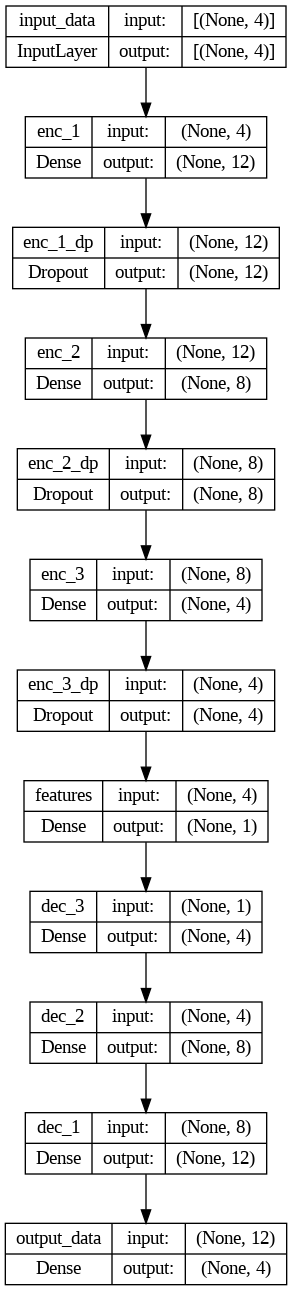

In [7]:
#@title Establecer el modelo DAE

#@markdown ### Parámetros de la Red:
rna_cant_neuronas_capas_ocultas = '12, 8, 4' #@param {type:"string"}
rna_neuronas_funcion_activacion = "relu" #@param ["linear", "relu", "sigmoid", "tanh"]
rna_cant_neuronas_capa_features = 1 #@param {type:"integer"}
rna_salida_funcion_activacion = "linear" #@param ["linear", "relu", "sigmoid", "tanh"]

#@markdown ### Parámetros para ayudar aprender a capas Encoder:
rna_valor_L1_activity_regularizer = True #@param {type:"boolean"}
#@markdown (Nota: si se indica verdadero, se agrega la restricción de las representaciones para que sean compactas en capas de Encoders - nunca en Decoders)

rna_porc_capa_DropOut = 0.2 #@param {type:"number"}
#@markdown (Nota: si se indica valor mayor a cero, se agregan capas DropOut en capas de Encoders - nunca en Decoders)


#@markdown ### Parámetros del Optimizador:
opt_tipo = "Adam" #@param ["Gradiente Decreciente", "Adam", "Adadelta", "Adagrad", "Adamax", "Nadam", "FTRL"]
opt_learning_rate = 0.05 #@param {type: "number"}

# define tamaño de datos de entrada y salida
num_inputs = len(x_train[0])
num_outputs = num_inputs

# cantidad de neuronas ocultas para features (datos comprimidos o codings)
if rna_cant_neuronas_capa_features < 1:
  num_features = 1
else:
  num_features = rna_cant_neuronas_capa_features


if opt_tipo == "Gradiente Decreciente":
  opt = keras.optimizers.SGD(learning_rate=opt_learning_rate)
elif opt_tipo == "Adam":
  opt = keras.optimizers.Adam(learning_rate=opt_learning_rate)
elif opt_tipo == "Adadelta":
  opt = keras.optimizers.Adadelta(learning_rate=opt_learning_rate)
elif opt_tipo == "Adagrad":
  opt = keras.optimizers.Adagrad(learning_rate=opt_learning_rate)
elif opt_tipo == "Adamax":
  opt = keras.optimizers.Adamax(learning_rate=opt_learning_rate)
elif opt_tipo == "Nadam":
  opt = keras.optimizers.Nadam(learning_rate=opt_learning_rate)
elif opt_tipo == "FTRL":
  opt = keras.optimizers.Ftrl(learning_rate=opt_learning_rate)
else:
  opt = keras.optimizers.Adam()


# cantidad de neuronas ocultas para la parte Encoder
#   (cada elemento de la lista es la cantidad de pesos que tiene cada una)
dae_layers = []
for val in rna_cant_neuronas_capas_ocultas.split(','):
  val = val.strip()
  dae_layers.append( int(val) )

#  agrega la capa de features a las capas
dae_layers.append( num_features )

# cantidad de neuronas ocultas para la parte Decoder
#   (usa la la lista de Encoder inversa)
for eachEncLayer in dae_layers[0:len(dae_layers)-1][::-1]:
  dae_layers.append( eachEncLayer )

if rna_porc_capa_DropOut > 0.9:
  rna_porc_capa_DropOut = 0.9

# define la arquitectura de capas del Deep Autoencoder
# teniendo en cuenta la definición dada anteriomente
input_data_Lay = tf.keras.layers.Input(shape=(num_inputs,), name='input_data') # capa de entrada
eachLay = input_data_Lay
auxName = 'enc_'
auxId = 1
for num_hid in dae_layers:

    # define el nombre de la capa oculta
    actReg_Dense = None
    if num_features==num_hid:
        # capa tipo Features
        auxlayerName = 'features'
        auxName = 'dec_'
        auxId = auxId - 1
    else:
        auxlayerName = auxName+str(auxId)
        if auxName == 'enc_':
          # capa tipo Encoder
          auxId = auxId + 1
          if rna_valor_L1_activity_regularizer:
            # agrega regulizer
            actReg_Dense = tf.keras.regularizers.l1(10e-5)
        else:
          # capa tipo Decoder
          auxId = auxId - 1

    # agrega la capa oculta
    eachLay = tf.keras.layers.Dense(num_hid,
                                    activation = rna_neuronas_funcion_activacion,
                                    activity_regularizer = actReg_Dense,
                                    name = auxlayerName)(eachLay) # capas ocultas

    if num_features==num_hid:
      # guarda capa Features
      features_Lay = eachLay

    # agrega capa Drop si es Encoder y se indica probabilidad > 0
    if (rna_porc_capa_DropOut>0.0) and (auxName == 'enc_'):
      eachLay = tf.keras.layers.Dropout(rna_porc_capa_DropOut,
                                        name = auxlayerName+"_dp")(eachLay)

# capa de salida
output_data_Lay =  tf.keras.layers.Dense(num_outputs,
                                         activation = rna_salida_funcion_activacion,
                                         name='output_data')(eachLay) # capa de salida

# genera el modelo Deep Autoencoder
DAEmodel = Model(input_data_Lay, output_data_Lay, name='DAE')

# dependiendo de la función de la capa de salida determinar cómo se calcula el loss
if (rna_salida_funcion_activacion == "sigmoid"):
  lossFunc = "binary_crossentropy"
else:
   lossFunc = "mse"

DAEmodel.compile(optimizer='adam', loss=lossFunc, metrics=['RootMeanSquaredError'])
##DAEmodel.compile(optimizer='adam', loss='binary_crossentropy')

print("Modelo DAE creado con ", len(DAEmodel.layers), " capas:")
DAEmodel.summary()
print("\n")
plot_model(DAEmodel, show_layer_names=True, show_shapes=True)


In [8]:
#@title Entrenar DAE

cant_epocas_entrenamiento = 1000 #@param {type:"integer"}

# cantidad de épocas del entrenamiento
cantEpocas = (1 if cant_epocas_entrenamiento<1 else cant_epocas_entrenamiento)

# determina datos para entrenar

# inicializa listtas auxiliares para entrenar
x_train_in = list( copy.deepcopy(x_train) )
x_train_out = list( copy.deepcopy(x_train) )

# si hay datos con ruido para agregar
if not(x_ruido_train_in is None) and (len(x_ruido_train_in)>0) and not(x_ruido_train_out is None) and (len(x_ruido_train_out)>0):
  x_train_in.extend( x_ruido_train_in )
  x_train_out.extend( x_ruido_train_out )

# prepara para que lo pueda usar el modelo
x_train_in = prepararDatos_X_Modelo( x_train_in )
x_train_out = prepararDatos_X_Modelo( x_train_out )

print("-- Cantidad de ejemplos para entrenar: ",  x_train_in.shape, "/", x_train_out.shape, "\n")

# lleva a cabo el entrenamiento
# usando los mismos datos como entrada y salida
history = DAEmodel.fit(x_train_in, x_train_out,
                epochs = cantEpocas,
                shuffle = True)


-- Cantidad de ejemplos para entrenar:  (262, 4) / (262, 4) 

Epoch 1/1000
9/9 [==============================] - 2s 4ms/step - loss: 16.3044 - root_mean_squared_error: 4.0356
Epoch 2/1000
9/9 [==============================] - 0s 4ms/step - loss: 16.1559 - root_mean_squared_error: 4.0171
Epoch 3/1000
9/9 [==============================] - 0s 4ms/step - loss: 15.8158 - root_mean_squared_error: 3.9746
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 15.5335 - root_mean_squared_error: 3.9389
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 15.1369 - root_mean_squared_error: 3.8882
Epoch 6/1000
9/9 [==============================] - 0s 4ms/step - loss: 14.5237 - root_mean_squared_error: 3.8084
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 14.0587 - root_mean_squared_error: 3.7468
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 13.5580 - root_mean_squared_error: 3.6793
Epoch 9/1000
9/9 [========

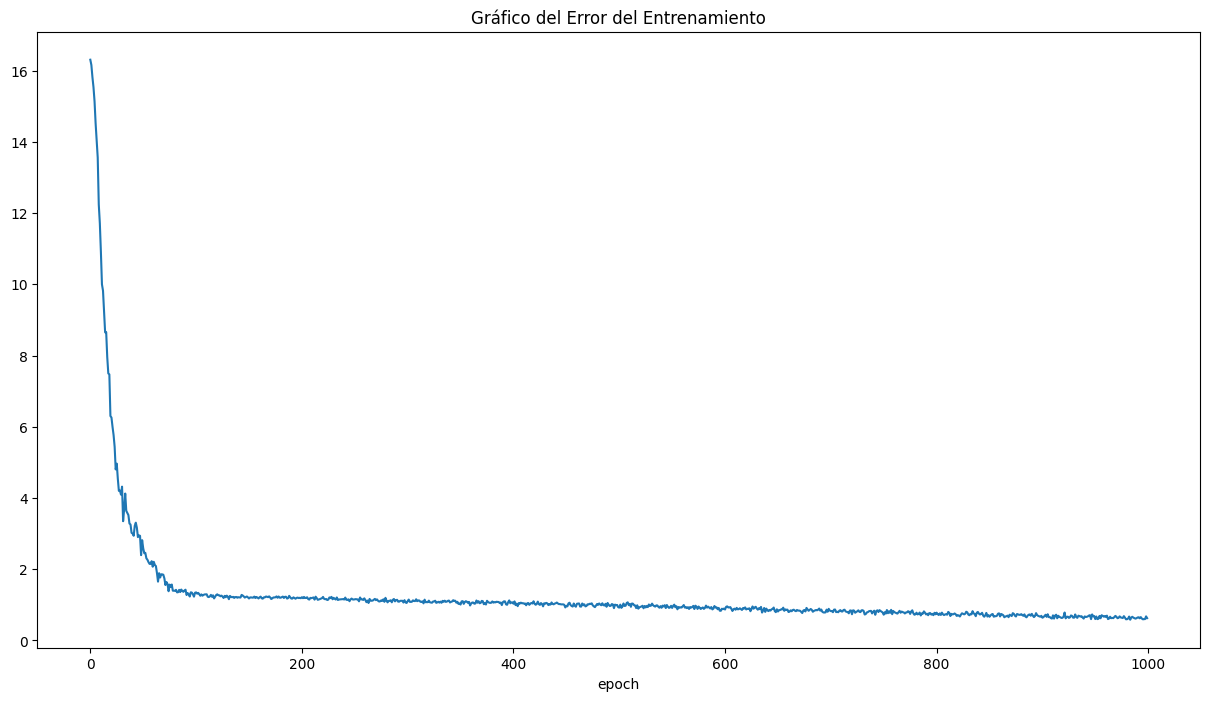

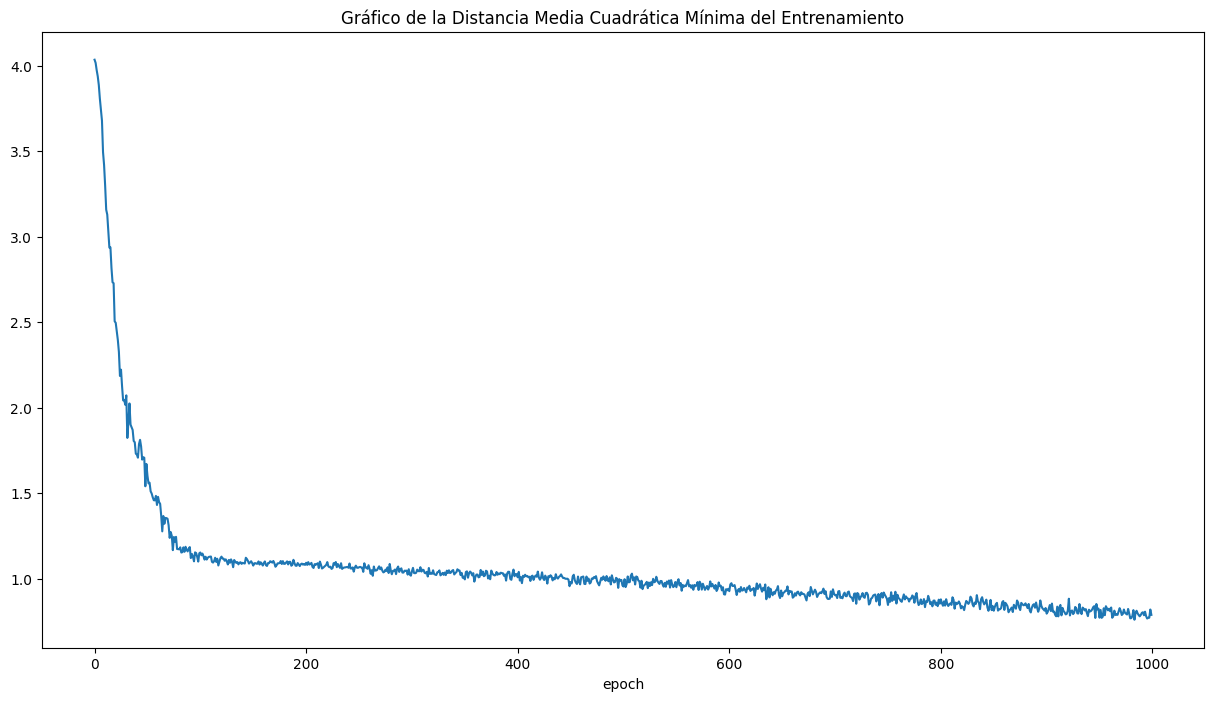

In [9]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.show()

plt.figure(figsize=(15,8))
plt.plot(history.history['root_mean_squared_error'])
plt.title('Gráfico de la Distancia Media Cuadrática Mínima del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.show()

In [10]:
#@title Probar DAE con datos de entrenamiento

probar_datos_entrenamiento_usar = "solo con ruido" #@param ["todos (originales y con ruido)", "solo originales", "solo con ruido"]
mostrar_detalle_entrenamiento = False #@param {type:"boolean"}

# función auxiliar para el cálculo de error
def calcErrores(pred, real):
  arAbs = []
  arRel = []

  for pV, r in zip(pred, real):
    # toma el valor estimado/predecido
    p = pV
    # controla que sean números
    if not(math.isnan(r) or math.isnan(p)):
      # hace los cálculos
      eAbs = abs(r - p)
      if r != 0:
        eRel = (eAbs / r)*100.0
      else:
        eRel = (eAbs / 0.00001)*100.0
      arAbs.append(eAbs)
      arRel.append(eRel)

  return arAbs, arRel

def generarGrafico(ar, tit, b=10, c=None):
     # genera gráfico de los errores
    fig = plt.figure(figsize=(15,5))
 #   ax = fig.add_axes( [0, 0, 0.8, 0.8] )
 #   ax.boxplot( [arAbs, arRel] )
 #   ax.set_xticklabels( ["Error Absoluto", "Error Relativo"] )
#    plt.legend(["Error Absoluto", "Error Relativo"], loc='best')
    plt.hist( ar, bins=b, color=c )
    plt.grid(color='lightgrey', which='both', axis='both', linestyle='solid', linewidth=0.3)
    plt.title("Distribución de "+ tit)
    plt.show()

# función auxiliar para fomatear datos reconstruidos a mostrar
def formatearDatos(data):
    format_data = []
    for v in data:
      format_data.append( round(v,2) )
    return format_data

# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_DAE(ori_data, ruido_data, atributos_entrada, detalle=False):

    # determina si hay datos con ruido para usar
    hayDatosConRuido = not((ruido_data is None) or (len(ruido_data)==0))

    print("\n")
    print("> Probar Modelo con ", len(ori_data), " ejemplos ", ("incluyendo ruido" if hayDatosConRuido else "sin ruido"), ":\n")

    # procesa las imágenes con el modelo
    if hayDatosConRuido:
      # usa datos con ruido para ejecutar el modelo
      reconstr_data = DAEmodel.predict(ruido_data, verbose=0)
    else:
      # usa datos originales para ejecutar el modelo
      reconstr_data = DAEmodel.predict(ori_data, verbose=0)

    if detalle:
      print("> Detalle:      ", atributos_entrada, "\n")
      for i in range(len(ori_data)):
          # muestra la real
          print("  + Original:   ", ori_data[i] )
          if hayDatosConRuido:
            # solo muestra si tienen  algún valor faltante
            if ejemploTieneValorFaltante( ruido_data[i] ):
              print("  - Con Ruido:  ", ruido_data[i] )
          # muestra la generada por el modelo con nros redondeados
          format_reconstr = formatearDatos( reconstr_data[i] )
          print("  * Modelo DAE: ", format_reconstr)
          # la diferencia siempre la calcula contra la original
          difs = []
          for j in range(len(ori_data[i])):
            if ori_data[i][j] == valor_usar_valores_faltantes:
              # pero si falta un valor considera que no hay diferencia
              d = 0.00
            else:
              d = format_reconstr[j] - ori_data[i][j]
            difs.append( d )
          print("  - Diferencia: ", formatearDatos(difs))
          print("")

    print("\n> Resumen Errores:")
    # genera transpuesta para poder calcular error por atributo
    # (siempre lo hace con los datos originales)
    ori_t = np.transpose( ori_data )
    rec_t = np.transpose( reconstr_data )

    # por cada atributo de X calcula errores
    for xName, xOri, xRecon in zip(atributos_entrada, ori_t, rec_t):

      print("  # "+ xName+ ":")
      # llama a la función de cálculo errror
      arAbs, arRel = calcErrores(xRecon, xOri)

      # muestra métricas
      print(" \tError Absoluto: ")
      print("            Mínimo: {:.5f} ".format(np.min(arAbs)) )
      print("            Promedio: {:.5f} ± {:.5f}".format(np.mean(arAbs), np.std(arAbs)) )
      print("            Máximo: {:.5f} ".format(np.max(arAbs)) )
      #generarGrafico(arAbs, "Error Absoluto", 20, "red")

      print(" \tError Relativo: ")
      print("            Mínimo: {:.2f}% ".format(np.min(arRel)) )
      print("            Promedio: {:.2f} ± {:.2f}".format(np.mean(arRel), np.std(arRel)) )
      print("            Máximo: {:.2f}% ".format(np.max(arRel)) )
      #generarGrafico(arRel, "Error Relativo", 10, "magenta")
      print("")

# determina datos para probar
if probar_datos_entrenamiento_usar == "solo con ruido":
  if (x_ruido_train_in is None) or (len(x_ruido_train_in)==0):
    raise Exception("No hay datos con ruido para probar!")

  prueba_x_sinRuido = prepararDatos_X_Modelo(x_ruido_train_out)
  prueba_x_conRuido = prepararDatos_X_Modelo(x_ruido_train_in)

elif probar_datos_entrenamiento_usar == "solo originales":
  prueba_x_sinRuido = prepararDatos_X_Modelo(x_train)
  prueba_x_conRuido = None

else: # "todos (originales y con ruido)"
  prueba_x_sinRuido = x_train_out
  prueba_x_conRuido = x_train_in

# ejecuta la prueba del modelo
probarModelo_DAE(prueba_x_sinRuido, prueba_x_conRuido,
                 atributos_entrada, mostrar_detalle_entrenamiento)



> Probar Modelo con  150  ejemplos  incluyendo ruido :


> Resumen Errores:
  # LargoSepalo:
 	Error Absoluto: 
            Mínimo: 0.00012 
            Promedio: 0.52631 ± 0.42017
            Máximo: 1.98311 
 	Error Relativo: 
            Mínimo: 0.00% 
            Promedio: 8.96 ± 7.15
            Máximo: 29.67% 

  # AnchoSepalo:
 	Error Absoluto: 
            Mínimo: 0.00353 
            Promedio: 0.31753 ± 0.23666
            Máximo: 0.88458 
 	Error Relativo: 
            Mínimo: 0.11% 
            Promedio: 10.46 ± 8.07
            Máximo: 35.05% 

  # LargoPetalo:
 	Error Absoluto: 
            Mínimo: 0.03842 
            Promedio: 1.06278 ± 0.65480
            Máximo: 2.99876 
 	Error Relativo: 
            Mínimo: 0.99% 
            Promedio: 43.89 ± 45.32
            Máximo: 196.67% 

  # AnchoPetalo:
 	Error Absoluto: 
            Mínimo: 0.00538 
            Promedio: 0.47761 ± 0.30655
            Máximo: 1.20743 
 	Error Relativo: 
            Mínimo: 0.38% 
         

9) Probar el modelo DAE entrenado con los datos de test:

In [11]:
#@title Probar DAE con datos de prueba

probar_datos_prueba_usar = "todos (originales y con ruido)" #@param ["todos (originales y con ruido)", "solo originales", "solo con ruido"]
#@markdown Nota: los datos con ruido se generan en el momento a partir de los ejemplos de prueba disponibles.
mostrar_detalle_prueba = True #@param {type:"boolean"}

# determina datos para probar
if probar_datos_prueba_usar == "solo originales":
  prueba_x_sinRuido = prepararDatos_X_Modelo(x_test)
  prueba_x_conRuido = None
else:
  # inicializa las listas
  if probar_datos_prueba_usar == "solo con ruido":
    prueba_x_sinRuido = []
    prueba_x_conRuido = []
  else:
    prueba_x_sinRuido = list( copy.deepcopy( x_test ) )
    prueba_x_conRuido = list( copy.deepcopy( x_test ) )
  # crea datos con ruido usando todos los de prueba
  for ejPrueba in x_test:
      # genera nuevo ejemplo con un valor faltante
      ejPrueba_conRuido = crearEjemploDatosFaltantes(ejPrueba,
                                                valor_usar_valores_faltantes,
                                                cant_atributos_modificar_con_valores_faltantes)
      prueba_x_sinRuido.append( ejPrueba )
      prueba_x_conRuido.append( ejPrueba_conRuido )
  # cambia formato para modelo
  prueba_x_sinRuido = prepararDatos_X_Modelo(prueba_x_sinRuido)
  prueba_x_conRuido = prepararDatos_X_Modelo(prueba_x_conRuido)

# ejecuta la prueba del modelo
probarModelo_DAE(prueba_x_sinRuido, prueba_x_conRuido,
                  atributos_entrada, mostrar_detalle_prueba)




> Probar Modelo con  76  ejemplos  incluyendo ruido :

> Detalle:       ['LargoSepalo', 'AnchoSepalo', 'LargoPetalo', 'AnchoPetalo'] 

  + Original:    [6.7 3.3 5.7 2.1]
  * Modelo DAE:  [6.45, 3.01, 4.92, 1.67]
  - Diferencia:  [-0.25, -0.29, -0.78, -0.43]

  + Original:    [6.2 3.4 5.4 2.3]
  * Modelo DAE:  [6.34, 3.05, 4.62, 1.54]
  - Diferencia:  [0.14, -0.35, -0.78, -0.76]

  + Original:    [5.8 2.7 5.1 1.9]
  * Modelo DAE:  [6.32, 3.06, 4.55, 1.51]
  - Diferencia:  [0.52, 0.36, -0.55, -0.39]

  + Original:    [6.4 2.7 5.3 1.9]
  * Modelo DAE:  [6.36, 3.04, 4.68, 1.57]
  - Diferencia:  [-0.04, 0.34, -0.62, -0.33]

  + Original:    [4.4 2.9 1.4 0.2]
  * Modelo DAE:  [4.99, 2.95, 2.46, 0.67]
  - Diferencia:  [0.59, 0.05, 1.06, 0.47]

  + Original:    [5.5 2.5 4.  1.3]
  * Modelo DAE:  [6.03, 3.19, 3.72, 1.14]
  - Diferencia:  [0.53, 0.69, -0.28, -0.16]

  + Original:    [6.9 3.1 5.1 2.3]
  * Modelo DAE:  [6.36, 3.04, 4.68, 1.57]
  - Diferencia:  [-0.54, -0.06, -0.42, -0.73]

  + O


# Sub-modelo Encoder:


In [12]:
#@title Generar el sub-modelo Encoder para Clustering
## (desde input hasta features)

# reutiliza las capas entrenadas del modelo DAE original
clust_input_Lay = input_data_Lay  # capa de entrada
clust_output_Lay =  features_Lay  # capa de salida

# genera el modelo
CLUSTmodel = Model(input_data_Lay, features_Lay, name='Encoder/Clustering')

print("> Modelo Encoder: ")
CLUSTmodel.summary()
#plot_model(CLUSTmodel, show_layer_names=True, show_shapes=True)

> Modelo Encoder: 
Model: "Encoder/Clustering"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_data (InputLayer)     [(None, 4)]               0         
                                                                 
 enc_1 (Dense)               (None, 12)                60        
                                                                 
 enc_1_dp (Dropout)          (None, 12)                0         
                                                                 
 enc_2 (Dense)               (None, 8)                 104       
                                                                 
 enc_2_dp (Dropout)          (None, 8)                 0         
                                                                 
 enc_3 (Dense)               (None, 4)                 36        
                                                                 
 enc_3_dp (Dropout)          

In [13]:
 #@title Generar Clustering
  # Muestra estadísticas y gráfico de los datos codificados

# determina datos a usar
usarDatos = 'Datos Entrenamiento' #@param ["Datos Entrenamiento", "Datos de Prueba"] {allow-input: false}
if usarDatos == 'Datos Entrenamiento':
  datosUsar = x_train
  datosUsar_y = y_train
else:
  datosUsar = x_test
  datosUsar_y = y_test

# procesa los datos para recibir el valor codificado de cada una
x_encoded = CLUSTmodel.predict(datosUsar)

# calcula estadisticas
minArClust = np.empty(num_features)
minArClust.fill(9999.99)
maxArClust = np.empty(num_features)
maxArClust.fill(-9999.99)
sumArClust = np.zeros(num_features)
for val in x_encoded:
  for i in range(num_features):
      sumArClust[i] = sumArClust[i]+val[i]
      if val[i]<minArClust[i]:
          minArClust[i] = val[i]
      if val[i]>maxArClust[i]:
          maxArClust[i] = val[i]
print("\n\n> Estadísticas de Clutering de Datos Originales codificado en ", num_features," features: ")
print("- Mínimos:   ", minArClust)
print("- Máximos:   ", maxArClust)
print("- Totales:   ", sumArClust)
print("- Promedios: ", sumArClust/len(x_encoded))
print("\n\n")

if len(x_encoded)>0 and len(x_encoded[0])>0:

  import ipywidgets as widgets
  from ipywidgets import Box, Layout


  #colValues = range(len(x_encoded[0]))
  colValues = []
  for col in range(len(x_encoded[0])):
    colValues.append("feature_"+str(col))

  # agrega los combos
  comboColX = widgets.Dropdown(
      options=colValues,
      value=colValues[0],
      description='Columna X:',
      disabled=False,
  )
  if len(colValues)>1:
    valYsel = colValues[1]
  else:
    valYsel = colValues[0]

  comboColY = widgets.Dropdown(
      options=colValues,
      value=valYsel,
      description='Columna Y:',
      disabled=False,
  )


  ui = widgets.HBox([comboColX, comboColY])

  import matplotlib.ticker as ticker

  def fmtClases(x, pos):
    return CLASES[int(x)]

  def cambiaSeleccion(fx, fy):
    # llama a la función
    # para generar el gráfico con las columnas seleccionadas
    # muestra el gráfico codificado
    plt.figure(figsize=(16, 10))
    x = int(fx.replace("feature_", ""))
    y = int(fy.replace("feature_", ""))
    plt.scatter(x_encoded[:,x], x_encoded[:,y], c=datosUsar_y, cmap='jet')
    plt.colorbar(format=ticker.FuncFormatter(fmtClases))
    plt.grid(color='grey', which='major', axis='y', linestyle='solid', linewidth=0.3)
    plt.grid(color='grey', which='major', axis='x', linestyle='solid', linewidth=0.3)
    plt.title("Representación de Datos Clusterizados", fontsize = 20)
    plt.show()

  out = widgets.interactive_output(cambiaSeleccion, {'fx': comboColX, 'fy': comboColY})
  display(ui, out)

4/4 [==============================] - 0s 4ms/step


> Estadísticas de Clutering de Datos Originales codificado en  1  features: 
- Mínimos:    [0.23656642]
- Máximos:    [7.71710968]
- Totales:    [334.98828495]
- Promedios:  [2.99096683]





Output()

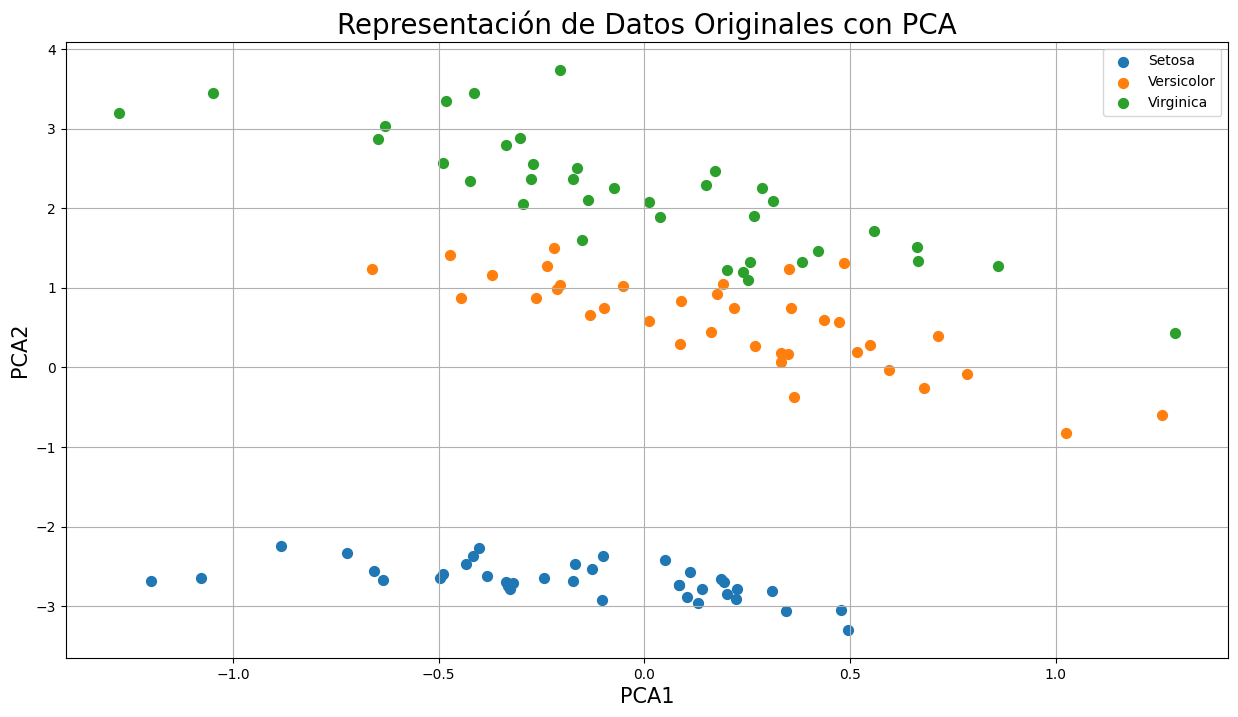

In [14]:
#@title Función auxiliar para generar gráfico PCA de comparación

# función auxiliar para generar un gráfico
# con los valores codificados
# usando PCA para simplificarlos en 2 ejes
def genera_grafico_pca(datos, clases, titulo):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(datos)
    principalDf = pd.DataFrame(data = principalComponents,
                columns = ['pca_1', 'pca_2'])
    finalDf = pd.concat([principalDf,
                        pd.DataFrame(clases, columns = ['target'])],
                        axis = 1)

    fig = plt.figure(figsize = (15,8))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('PCA1', fontsize = 15)
    ax.set_ylabel('PCA2', fontsize = 15)
    ax.set_title(titulo, fontsize = 20)
    for target in set(clases):
        indicesToKeep = finalDf['target'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'pca_2'],
                  finalDf.loc[indicesToKeep, 'pca_1'],
                  s = 50)
    ax.legend(CLASES[1:])
    ax.grid()


# muestra el gráfico con originales con PCA (para que tenga 2 dimensiones)
generar_grafico_PCA = True #@param{type:"boolean"}
if generar_grafico_PCA:
  genera_grafico_pca(datosUsar, datosUsar_y, "Representación de Datos Originales con PCA")


In [15]:
#@title Aplicar Algoritmo de Inducción usando como entrada valores de Features/Clusters

from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(clf, x, y, clases_map, mostrarDetalle=False):

    # procesa las imágenes de prueba con el modelo
    predClass = clf.predict(x)

    # muestra los resultados con las imágenes
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # prepara salida
        clReal = y[i]
        clPred = predClass[i]

        classReal.append( clReal )
        classPreds.append( clPred )

        strTitulo = 'Real: ' + clReal + ' / Modelo(Árbol): '
        strTitulo = strTitulo + clPred
        strTitulo = strTitulo + ": " + ("ok" if (clPred==clReal) else "error!")

        # muestra comparación con la imagen
        if mostrarDetalle:
          print(strTitulo)

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm,
        index=['r:{:}'.format(x) for x in clases_map],
        columns=['m:{:}'.format(x) for x in clases_map]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    cmtx.sort_index(axis=0, inplace=True)
    cmtx.sort_index(axis=1, inplace=True)
    print(cmtx)
    print("\n")


if len(x_encoded)>0 and len(x_encoded[0])>0:

  # parámetros
  param_criterio = "Gini impurity" #@param ["Entropy", "Error", "Gini impurity"]
  if param_criterio == "Entropy":
    pCriteria = "entropy"
  elif param_criterio == "Error":
    pCriteria = "log_loss"
  #elif param_criterio == "Gini impurity":
  else:
    pCriteria = "gini"
  param_max_depth = 0 #@param {type:"number"}
  if param_max_depth < 1:
      # menor que 1 es opcional
      param_max_depth = None
  param_split_strategy = "Best" #@param ["Best", "Random"]
  if param_split_strategy== "Best":
    pSpliter = "best"
  #elif param_split_strategy == "Random":
  else:
    pSpliter = "random"
  param_min_samples_split  = 0 #@param {type:"number"}
  if param_min_samples_split  < 2:
      param_min_samples_split  = 2
  param_min_samples_leaf  = 1 #@param {type:"number"}
  if param_min_samples_leaf  < 1:
      param_min_samples_leaf  = 1
  param_max_leaf_nodes = 0 #@param {type:"number"}
  if param_max_leaf_nodes < 2:
      param_max_leaf_nodes = None

  # preparar datos
  x_encoded_train = CLUSTmodel.predict(x_train)
  y_clases_train = [CLASES[y] for y in y_train]
  x_encoded_test = CLUSTmodel.predict(x_test)
  y_clases_test = [CLASES[y] for y in y_test]

  # genera el árbol y lo muestra
  clf = tree.DecisionTreeClassifier(criterion=pCriteria,
                                    splitter=pSpliter,
                                    max_depth=param_max_depth,
                                    min_samples_split=param_min_samples_split,
                                    min_samples_leaf=param_min_samples_leaf,
                                    max_leaf_nodes=param_max_leaf_nodes)

  clf = clf.fit(x_encoded_train, y_clases_train)

  # muestra las reglas
  r = tree.export_text(clf)

  print("> Reglas:" )
  print(r)

  # prueba con los datos de entrenamiento
  print("\n*** Resultados con datos de Entrenamiento: ")
  probarModelo(clf, x_encoded_train, y_clases_train, CLASES, False)

  # prueba con los datos de entrenamiento
  print("\n*** Resultados con datos de Prueba: ")
  probarModelo(clf, x_encoded_test, y_clases_test, CLASES, False)




2/2 [==============================] - 0s 4ms/step
> Reglas:
|--- feature_0 <= 0.84
|   |--- class: Setosa
|--- feature_0 >  0.84
|   |--- feature_0 <= 4.26
|   |   |--- feature_0 <= 3.79
|   |   |   |--- class: Versicolor
|   |   |--- feature_0 >  3.79
|   |   |   |--- feature_0 <= 4.11
|   |   |   |   |--- feature_0 <= 3.89
|   |   |   |   |   |--- class: Virginica
|   |   |   |   |--- feature_0 >  3.89
|   |   |   |   |   |--- feature_0 <= 3.97
|   |   |   |   |   |   |--- class: Versicolor
|   |   |   |   |   |--- feature_0 >  3.97
|   |   |   |   |   |   |--- class: Virginica
|   |   |   |--- feature_0 >  4.11
|   |   |   |   |--- class: Versicolor
|   |--- feature_0 >  4.26
|   |   |--- feature_0 <= 4.77
|   |   |   |--- feature_0 <= 4.68
|   |   |   |   |--- feature_0 <= 4.44
|   |   |   |   |   |--- feature_0 <= 4.36
|   |   |   |   |   |   |--- class: Virginica
|   |   |   |   |   |--- feature_0 >  4.36
|   |   |   |   |   |   |--- class: Versicolor
|   |   |   |   |--- featur


# Sub-modelo Decoder:


In [16]:
#@title Generar el sub-modelo Decoder como Generator
## (desde features hasta output)

# genera una copia del modelo DAE original para evitar romperlo
auxiCloneModel = keras.models.model_from_json(DAEmodel.to_json())
#auxiCloneModel.summary()

# genera la nueva estructura del Generator
input_gen = tf.keras.layers.Input(shape=(num_features,), name='input_gen') # nueva capa de entrada
auxLay_gen = input_gen
for pos in range(len(DAEmodel.layers)):

  # obtiene el nombre de la capa actual
  auxName = DAEmodel.layers[pos].name

  # sólo considera las capas luego de features (decoder y output)
  # para copiar los pesos del DAE original y actualizar la estructura
  if auxName.startswith('dec_') or auxName=='output_data':
    auxiCloneModel.layers[pos].set_weights(DAEmodel.layers[pos].get_weights())
    auxLay_gen = auxiCloneModel.layers[pos](auxLay_gen)

# crea el nuevo modelo Generator
GENmodel = Model(input_gen, auxLay_gen, name = 'Decoder/Generator')

print("> Modelo Decoder: ")
GENmodel.summary()
#plot_model(GENmodel, show_layer_names=True, show_shapes=True)

> Modelo Decoder: 
Model: "Decoder/Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_gen (InputLayer)      [(None, 1)]               0         
                                                                 
 dec_3 (Dense)               (None, 4)                 8         
                                                                 
 dec_2 (Dense)               (None, 8)                 40        
                                                                 
 dec_1 (Dense)               (None, 12)                108       
                                                                 
 output_data (Dense)         (None, 4)                 52        
                                                                 
Total params: 208 (832.00 Byte)
Trainable params: 208 (832.00 Byte)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________

In [17]:
#@title Ejecuta el Generator con Features al Azar
#  usando valores definidos al azar como datos de entrada
cantGenerar = 10 #@param {type:"integer"}

# genera los datos de entrada
# (como la codificación tiene varias posiciones con ceros
# se considera que sólo se ponen al azar entre 10% y el 70% de los valores, el resto queda en cero,
# --sino se podría hacer con " np.random.rand(cantGenerar, num_features) "-- )
arX = []
minRnd = 1
maxRnd = num_features+1
for i in range(cantGenerar):
  X = np.zeros(num_features)
  #for j in range(np.random.randint(low=minRnd, high=maxRnd)):
      #pos = np.random.randint(low=0, high=num_features)
  for pos in range(0, num_features):
      # si están definidas las estadisticas las usa, sino no
      if (minArClust is None or maxArClust is None):
          X[pos] = np.random.uniform()
      else:
          X[pos] = np.random.uniform(minArClust[pos], maxArClust[pos])
  arX.append( X )

# ejecuta el modelo Generator
reconstr_data_gen = GENmodel.predict( np.array(arX).reshape((len(arX), num_features)), verbose=0 )

# muestra las imágenes generadas
print("\n> Resultados: ")
# muestra las 15 primeras imágenes
print("\n> Ejemplos de Resultados: ", atributos_entrada, "\n")
for i in range(len(arX)):

    # muestra features
    print("  + Random Features: ", arX[i])

     # muestra la generada por el modelo con nros redondeados
    format_reconstr_data_gen = formatearDatos( reconstr_data_gen[i] )
    print("  * Generado Modelo: ", format_reconstr_data_gen)

    print("\n")




> Resultados: 

> Ejemplos de Resultados:  ['LargoSepalo', 'AnchoSepalo', 'LargoPetalo', 'AnchoPetalo'] 

  + Random Features:  [6.87644134]
  * Generado Modelo:  [6.59, 2.95, 5.33, 1.86]


  + Random Features:  [0.30119107]
  * Generado Modelo:  [5.03, 2.96, 2.49, 0.69]


  + Random Features:  [5.81562315]
  * Generado Modelo:  [6.45, 3.01, 4.92, 1.67]


  + Random Features:  [7.42746129]
  * Generado Modelo:  [6.67, 2.91, 5.55, 1.95]


  + Random Features:  [7.46829195]
  * Generado Modelo:  [6.67, 2.91, 5.56, 1.96]


  + Random Features:  [4.27545124]
  * Generado Modelo:  [6.23, 3.1, 4.31, 1.4]


  + Random Features:  [0.90106373]
  * Generado Modelo:  [5.4, 3.09, 2.84, 0.8]


  + Random Features:  [2.30116096]
  * Generado Modelo:  [5.96, 3.22, 3.53, 1.06]


  + Random Features:  [2.76333142]
  * Generado Modelo:  [6.03, 3.19, 3.72, 1.14]


  + Random Features:  [6.03717071]
  * Generado Modelo:  [6.48, 3.0, 5.0, 1.71]




In [18]:
#@title Ejecuta el Generator con Features Personalizados

import ipywidgets as widgets
from ipywidgets import Box, Layout


if colValues is not None and len(colValues) > 0:
  fValueList = []
  for i in range(len(colValues)):
      fValue = widgets.FloatSlider(
        value=0.0,
        min=-100,
        max=100.0,
        step=0.1,
        description=colValues[i] + ':',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
      )
      fValueList.append(fValue)

  button = widgets.Button(description="Generar")

  def on_button_clicked(b):
      with out:
          X = []
          for i in range(len(fValueList)):
            X.append( fValueList[i].value )

          # ejecuta el modelo Generator
          arX= [X]
          reconstr_data_gen = GENmodel.predict( np.array(arX).reshape((len(arX), num_features)), verbose=0 )

          global primeraVezEjecuta_on_button_clicked
          if primeraVezEjecuta_on_button_clicked:
            print("\n> Resultados: ", atributos_entrada, "\n")
            primeraVezEjecuta_on_button_clicked = False

          # muestra features
          print("  + Features Usuario: ", X)

          # muestra la generada por el modelo con nros redondeados
          format_reconstr_data_gen = formatearDatos( reconstr_data_gen[0] )
          print("  * Generado Modelo:  ", format_reconstr_data_gen)

          print("\n")


  button.on_click(on_button_clicked)

  primeraVezEjecuta_on_button_clicked = True

  ui = widgets.HBox(fValueList + [button])
  out = widgets.Output()
  display(ui, out)
  print("\n")




Output()




> Resultados:  ['LargoSepalo', 'AnchoSepalo', 'LargoPetalo', 'AnchoPetalo'] 

  + Features Usuario:  [0.0]
  * Generado Modelo:   [4.85, 2.9, 2.32, 0.63]


  + Features Usuario:  [100.0]
  * Generado Modelo:   [19.37, -2.56, 41.92, 18.0]


  + Features Usuario:  [-100.0]
  * Generado Modelo:   [2.76, -12.53, 23.46, 22.28]


